In [2]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import cv2 as cv
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


# from utils import io, abi, glm, nexrad
from tobac_flow import io, abi, glm, nexrad
from tobac_flow.plotting import goes_figure
from tobac_flow.flow import Flow
from tobac_flow import legacy_flow as lf

# Filter some warnings because pyart doesn't work nicely with notebooks

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# Load files
goes_data_path = '../data/GOES16'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = io.find_abi_files(dates, satellite=16, product='MCMIP', view='C', mode=3, 
                              save_dir=goes_data_path, 
                              replicate_path=True, check_download=True, 
                              n_attempts=1, download_missing=True)
             

abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))

# Get time difference (in seconds) between each file
dt = [(abi_dates[1]-abi_dates[0]).total_seconds()/60] \
     + [(abi_dates[i+2]-abi_dates[i]).total_seconds()/120 \
        for i in range(len(abi_files)-2)] \
     + [(abi_dates[-1]-abi_dates[-2]).total_seconds()/60]
dt = np.array(dt)

# Test with some multichannel data
ds_slice = {'x':slice(1325,1475), 'y':slice(725,850)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)

48


In [4]:
# Extract fields and load into memory
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
try:
    wvd = wvd.compute()
except AttributeError:
    pass

bt = goes_ds.CMI_C13
try:
    bt = bt.compute()
except AttributeError:
    pass

swd = goes_ds.CMI_C13 - goes_ds.CMI_C15
try:
    swd = swd.compute()
except AttributeError:
    pass

In [5]:
flow_kwargs = {'pyr_scale':0.5, 'levels':6, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

In [13]:
# Get growth_rate of the wvd field and find markers
from tobac_flow.detection import detect_growth_markers
wvd_growth, growth_markers = detect_growth_markers(flow, wvd)

In [14]:
# Watershed anvil regions connected to growth markers
from tobac_flow.detection import edge_watershed
inner_watershed = edge_watershed(flow, wvd-swd, growth_markers!=0, -5, -15)


In [15]:
from tobac_flow.analysis import filter_labels_by_length_and_mask
inner_labels = filter_labels_by_length_and_mask(flow.label(inner_watershed), growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(inner_labels!=0))
print('Detected anvils: n =', inner_labels.max())


Detected anvils: area = 123872
Detected anvils: n = 2


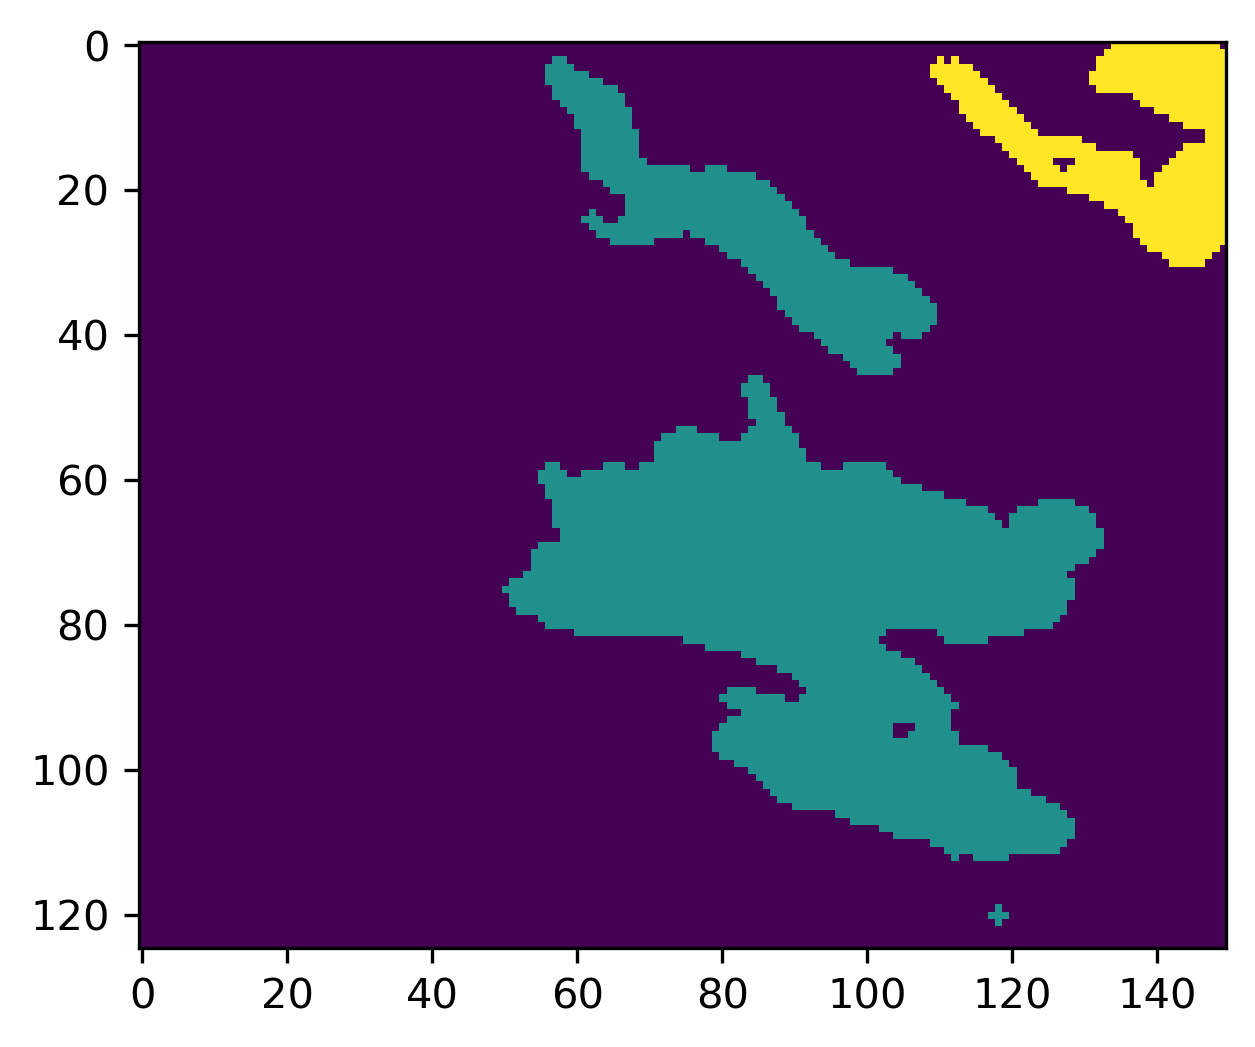

In [16]:
plt.figure(dpi=300)
plt.imshow(inner_labels[36])

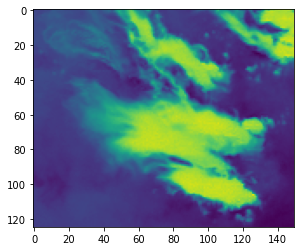

In [20]:
plt.imshow(wvd[36])

In [17]:
from tobac_flow.analysis import flat_label
flat_inner = flat_label(inner_labels)

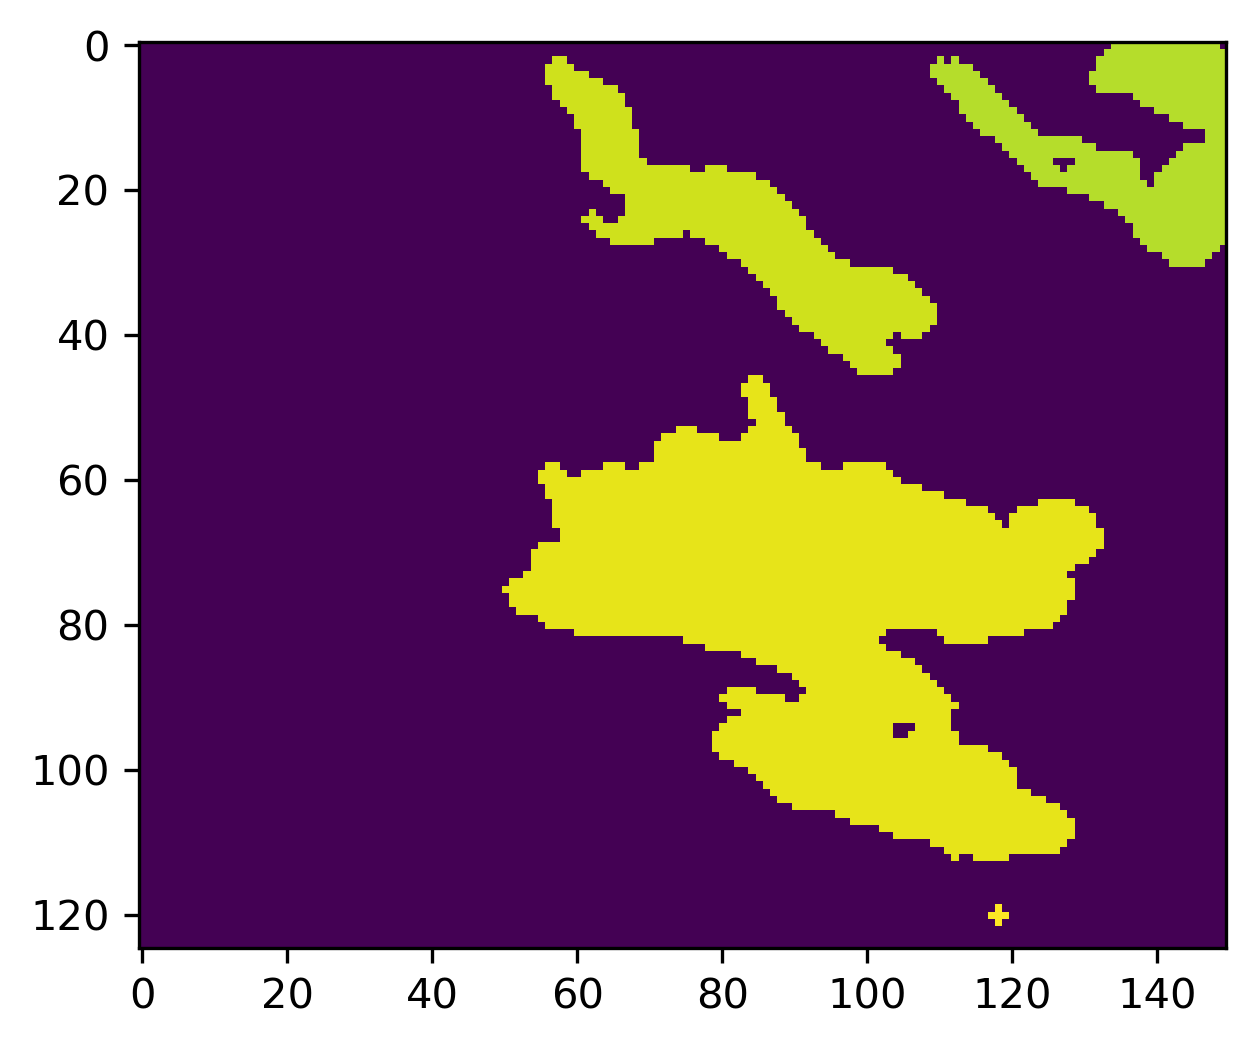

In [18]:
plt.figure(dpi=300)
plt.imshow(flat_inner[36],vmin=144)

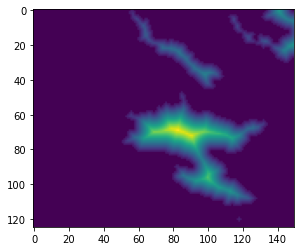

In [18]:
plt.imshow(ndi.morphology.distance_transform_edt(flat_inner[36]!=0))

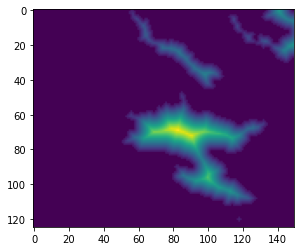

In [24]:
plt.imshow(ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])[36])

In [25]:
flat_inner_distances = ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])

In [28]:
flat_radii = (np.bincount(flat_inner.ravel())/np.pi)**0.5

In [29]:
flat_radii

array([497.95060696,   5.47002096,   2.03421447,   1.59576912,
         6.67558118,   2.82094792,   2.25675833,   7.75632442,
         3.09019362,   2.98541066,   8.61198023,   3.3851375 ,
         3.612576  ,   9.50789186,   3.86788891,   4.65242649,
        10.0609415 ,   7.35613218,  10.80831755,   8.61198023,
        11.34007028,   9.80456963,   1.26156626,  11.5762024 ,
        10.82303276,   1.59576912,  12.20528684,  12.12679543,
        12.75367993,  13.13483758,  13.4934523 ,  13.90014751,
         2.52313252,   1.95441005,  14.04820734,  14.74468217,
         3.43183126,   2.25675833,  14.31752656,  15.32686191,
         4.25953795,  15.14930454,   1.95441005,  15.86767532,
         4.91849076,  15.48183918,   1.26156626,   1.26156626,
         2.93161507,  16.48746927,   5.67003514,  16.07692842,
         1.26156626,   1.87120516,   3.74241032,  17.12201522,
         6.3580937 ,  17.26088218,   1.59576912,   2.32621325,
        17.92134691,   6.86366252,  25.76808923,   1.26

In [30]:
ndi.morphology.distance_transform_edt(flat_inner[36]!=0)

array([[0.        , 0.        , 0.        , ..., 2.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.23606798, 1.41421356,
        1.        ],
       [0.        , 0.        , 0.        , ..., 2.82842712, 2.23606798,
        2.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [35]:
np.bincount(flat_label(inner_labels[36][np.newaxis])[0].ravel())

array([15025,   640,   515,  2565,     5])

In [39]:
from tobac_flow.analysis import flat_label
flat_inner = flat_label(inner_labels)
pixel_counts = np.bincount(flat_inner.ravel())
dist_mask = ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])/((pixel_counts/np.pi)**0.5)[flat_inner]

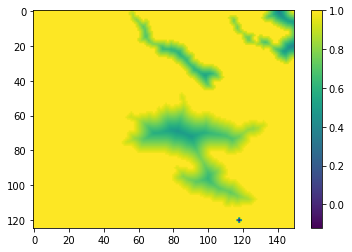

In [72]:
plt.imshow(1-dist_mask[36])
plt.colorbar()

In [41]:
thresh = 0.1

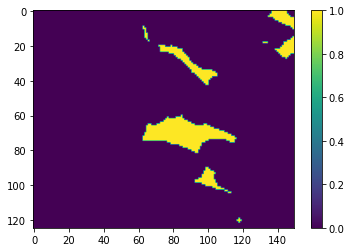

In [46]:
plt.imshow(dist_mask[36]>0.25)
plt.colorbar()

In [51]:
thresh = 0.1
shrunk_labels = flat_label(dist_mask>thresh)
shrunk_markers = shrunk_labels.copy()
shrunk_markers[flat_inner==0] = -1

In [58]:
struct = ndi.generate_binary_structure(3,1)
struct[0] = 0
struct[-1] = 0
subseg_labels = ndi.watershed_ift((np.minimum(dist_mask,1)*255).astype(np.uint8), shrunk_markers, struct)
subseg_labels[flat_inner==0] = 0

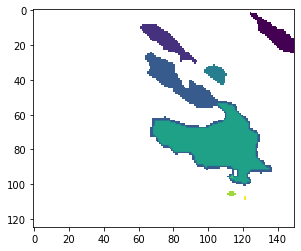

In [71]:
plt.imshow(ma.array(subseg_labels[23], mask=flat_inner[23]==0))

In [84]:
def subsegment_labels(input_mask, shrink_factor=0.1):
    from tobac_flow.analysis import flat_label
    from skimage.segmentation import watershed
    labels = flat_label(input_mask!=0)
    pixel_counts = np.bincount(labels.ravel())
    dist_mask = ndi.morphology.distance_transform_edt(labels, [1e9,1,1])/((pixel_counts/np.pi)**0.5)[labels]
    shrunk_labels = flat_label(dist_mask>shrink_factor)
    shrunk_markers = shrunk_labels.copy()
    shrunk_markers[flat_inner==0] = -1
    struct = ndi.generate_binary_structure(3,1)
    struct[0] = 0
    struct[-1] = 0
    subseg_labels = np.zeros_like(labels)
    for i in range(subseg_labels.shape[0]):
        subseg_labels[i] = watershed(-dist_mask[i], shrunk_markers[i], mask=flat_inner[i]!=0)
    
    return subseg_labels

In [85]:
subsegment_labels(inner_labels)[36]

array([[  0,   0,   0, ..., 179, 179,   0],
       [  0,   0,   0, ..., 179, 179, 179],
       [  0,   0,   0, ..., 179, 179, 179],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

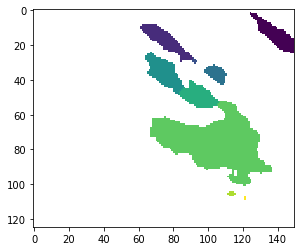

In [92]:
plt.imshow(ma.array(subsegment_labels(inner_labels, 0.2)[23], mask=flat_inner[23]==0))

In [74]:
from skimage.segmentation import watershed


In [83]:
watershed?

In [21]:
def subsegment_labels(input_mask, shrink_factor=0.1):
    from tobac_flow.analysis import flat_label
    from skimage.segmentation import watershed
    labels = flat_label(input_mask!=0)
    pixel_counts = np.bincount(labels.ravel())
    dist_mask = ndi.morphology.distance_transform_edt(labels, [1e9,1,1])/((pixel_counts/np.pi)**0.5)[labels]
    shrunk_labels = flat_label(dist_mask>shrink_factor)
    shrunk_markers = shrunk_labels.copy()
    shrunk_markers[flat_inner==0] = -1
    struct = ndi.generate_binary_structure(3,1)
    struct[0] = 0
    struct[-1] = 0
    subseg_labels = np.zeros_like(labels)
    for i in range(subseg_labels.shape[0]):
        subseg_labels[i] = watershed(-dist_mask[i], shrunk_markers[i], mask=flat_inner[i]!=0)
    
    return subseg_labels

# implement minimum overlap for flow_label function
def flow_label(flow, mask, structure=ndi.generate_binary_structure(3,1), dtype=np.int32, overlap=0, subsegment_shrink=0):
    """
    Label 3d connected objects in a semi-Lagrangian reference frame
    """
    from tobac_flow.analysis import flat_label
    from collections import deque
#     Get flat (2d) labels
    if subsegment_shrink == 0:
        flat_labels = flat_label(mask.astype(bool), structure=structure).astype(dtype)
    else:
        flat_labels = subsegment_labels(mask.astype(bool), shrink_factor=subsegment_shrink)

    back_labels, forward_labels = flow.convolve(flat_labels, method='nearest', dtype=dtype,
                                              structure=structure*np.array([1,0,1])[:,np.newaxis, np.newaxis])

    processed_labels = []
    label_map = {}

    bins = np.cumsum(np.bincount(flat_labels.ravel()))
    args = np.argsort(flat_labels.ravel())

    for label in range(1, bins.size):
        if label not in processed_labels:
            label_map[label] = [label]
            processed_labels.append(label)

            i = 0
            while i < len(label_map[label]):
                find_neighbour_labels(label_map[label][i], label_map[label], bins, args,
                                      processed_labels, forward_labels, back_labels,
                                      overlap=overlap)
                i+=1

    new_labels = np.zeros(mask.shape, dtype=dtype)

    for ik, k in enumerate(label_map):
        for i in label_map[k]:
            if bins[i]>bins[i-1]:
                new_labels.ravel()[args[bins[i-1]:bins[i]]] = ik+1

    assert np.all(new_labels.astype(bool)==mask.astype(bool))
    return new_labels

def find_neighbour_labels(label, label_stack, bins, args, processed_labels,
                          forward_labels, back_labels, overlap=0):
    """
    Find the neighbouring labels at the previous and next time steps to a given
    label
    """
    if bins[label]>bins[label-1]: #check that there are any pixels in this label
        forward_lap = forward_labels.ravel()[args[bins[label-1]:bins[label]]]
        forward_bins = np.bincount(np.maximum(forward_lap,0))
        for new_label in np.unique(forward_lap):
            if (new_label>0 and 
                new_label not in processed_labels and 
                forward_bins[new_label] >= overlap*np.minimum(bins[label]-bins[label-1], bins[new_label]-bins[new_label-1])):
                
                label_stack.append(new_label)
                processed_labels.append(new_label)
                
        backward_lap = back_labels.ravel()[args[bins[label-1]:bins[label]]]
        backward_bins = np.bincount(np.maximum(backward_lap,0))
        for new_label in np.unique(backward_lap):
            if (new_label>0 and 
                new_label not in processed_labels and 
                backward_bins[new_label] >= overlap*np.minimum(bins[label]-bins[label-1], bins[new_label]-bins[new_label-1])):
                
                label_stack.append(new_label)
                processed_labels.append(new_label)


In [22]:
test_labels = filter_labels_by_length_and_mask(flow_label(flow, inner_watershed, overlap=0.75, subsegment_shrink=0.25), growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(test_labels!=0))
print('Detected anvils: n =', test_labels.max())


Detected anvils: area = 123358
Detected anvils: n = 3


In [23]:
np.bincount(test_labels.ravel())

array([776642,  90615,  15539,  17204])

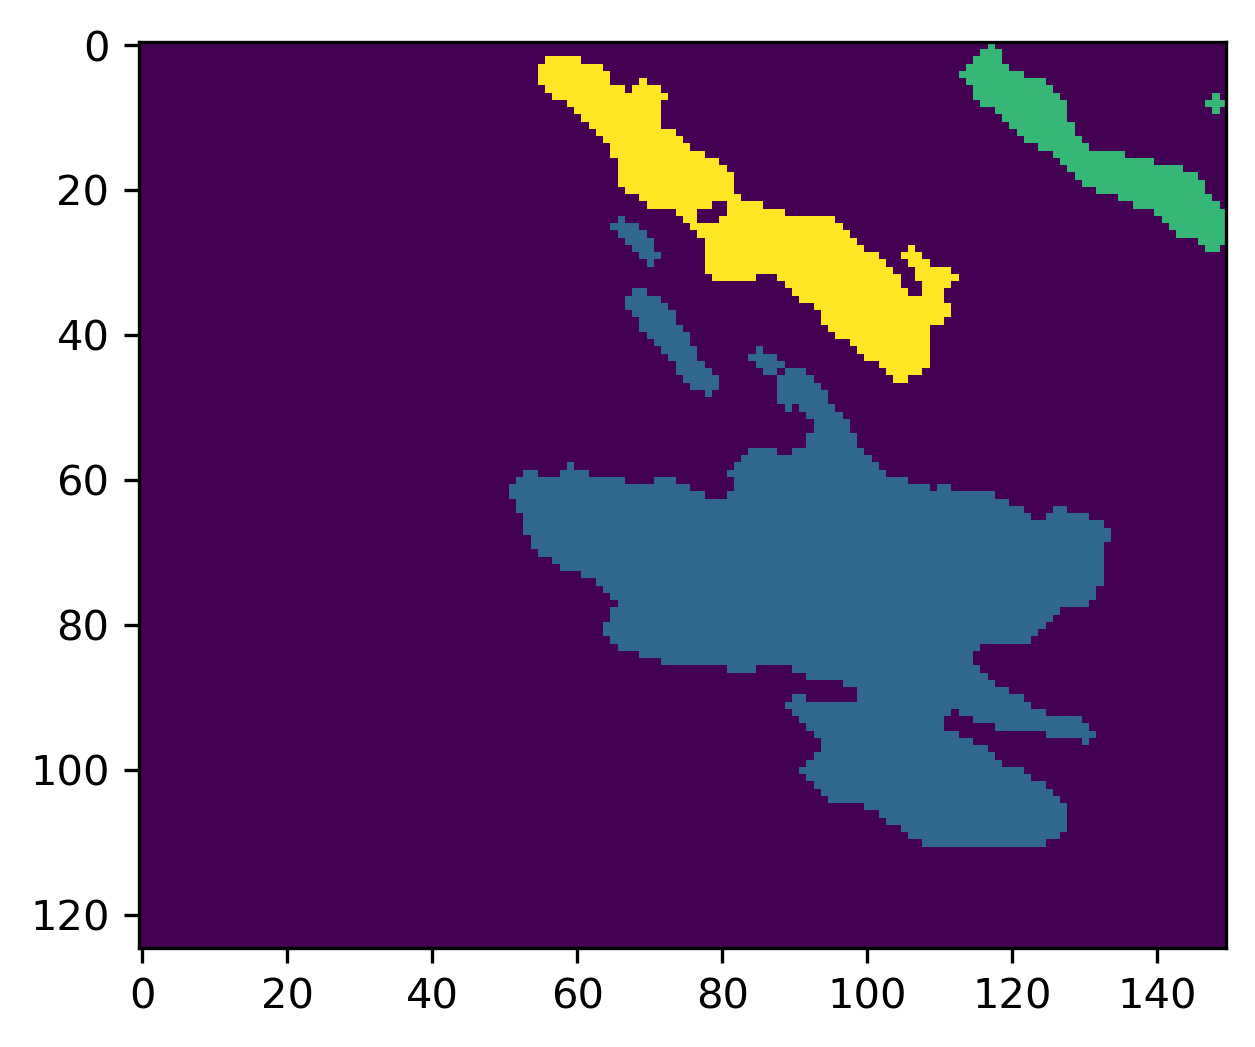

In [24]:
plt.figure(dpi=300)
plt.imshow(test_labels[31])

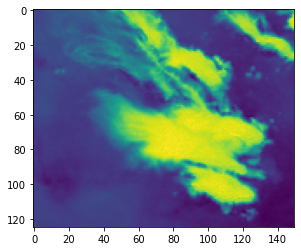

In [26]:
plt.imshow(wvd[31])

In [146]:
flow._warp_flow_step?

In [147]:
stencil = ndi.generate_binary_structure(2,1)

In [150]:
np.where(stencil)

(array([0, 1, 1, 1, 2]), array([1, 0, 1, 2, 1]))

In [27]:
def _warp_flow_step(self, img, step, method='linear', direction='forward', 
                    stencil=ndi.generate_binary_structure(2,1)):
    if img.shape != self.shape[1:]:
        raise ValueError("Image shape does not match flow shape")
    if method == 'linear':
        method = cv.INTER_LINEAR
    elif method =='nearest':
        method = cv.INTER_NEAREST
    else:
        raise ValueError("method must be either 'linear' or 'nearest'")
    
    h, w = self.shape[1:]
    n = np.sum(stencil!=0)
    offsets = np.stack(np.where(stencil!=0), -1)[:,np.newaxis,np.newaxis,:]-1
    locations = np.tile(offsets, [1,h,w,1]).astype(np.float32)
    locations += np.stack(np.meshgrid(np.arange(w), np.arange(h)), -1)
    if direction=='forward':
        locations += self.flow_for[step]
    elif direction=='backward':
        locations += self.flow_back[step]
    
    out_img = np.full([n,h*2], np.nan).astype(img.dtype)
    return cv.remap(img, locations.reshape([n,-1,2]), None, 
                        method, out_img, cv.BORDER_CONSTANT, np.nan).reshape([n,h,w])
    

In [28]:
_warp_flow_step(flow, bt[24].data, 24)

array([[[      nan, 297.14786, 298.3155 , ..., 285.7655 , 287.81454,
               nan],
        [      nan, 297.14786, 299.42163, ..., 285.71036, 283.737  ,
               nan],
        [      nan, 298.0082 , 298.4384 , ..., 279.0434 , 282.83597,
         286.69397],
        ...,
        [      nan, 296.1646 , 296.1646 , ..., 302.0027 , 302.67865,
         223.93704],
        [      nan, 296.10315, 296.04172, ..., 302.30994, 301.5725 ,
         229.98708],
        [      nan,       nan,       nan, ..., 242.01631, 239.33638,
         237.5324 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [297.14786, 298.3155 , 297.3322 , ..., 288.88904, 286.98328,
               nan],
        [297.14786, 299.42163, 296.2875 , ..., 283.89175, 284.75967,
               nan],
        ...,
        [296.2875 , 296.22607, 296.2875 , ..., 301.75687, 301.81833,
         217.67743],
        [296.1646 , 296.1646 , 296.1646 , ..., 302.67865, 302.98593,
   

In [172]:
before = flow.sobel(bt)
%timeit flow.sobel(bt)

754 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


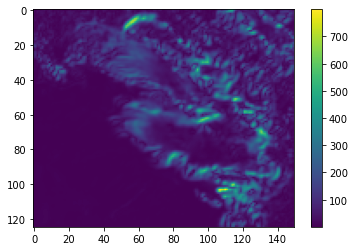

In [174]:
plt.imshow(before[24])
plt.colorbar()

In [176]:
from importlib import reload
import tobac_flow
reload(tobac_flow)
from tobac_flow.flow import Flow
flow_kwargs = {'pyr_scale':0.5, 'levels':6, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

In [10]:
after = flow.sobel(bt)
%timeit flow.sobel(bt)

589 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


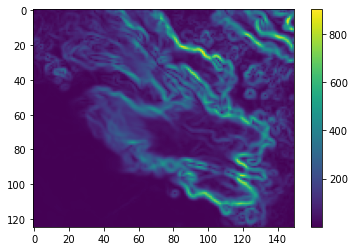

In [27]:
plt.imshow(after[31])
plt.colorbar()

In [6]:
test = flow.convolve(bt, structure=np.ones((3,3,3)))

In [7]:
test.shape

(27, 48, 125, 150)

In [8]:
np.all(test[13,24]==bt[24])

<xarray.DataArray 'CMI_C13' ()>
array(True)
Coordinates:
    t        datetime64[ns] 2018-06-19T19:03:43.334675968
    y_image  float32 0.08624
    x_image  float32 -0.03136

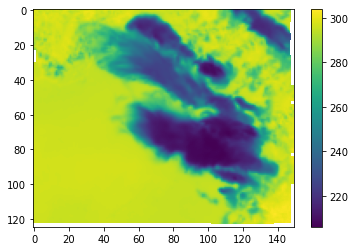

In [12]:
plt.imshow(test[5,24])
plt.colorbar()